In [347]:
import numpy as np 
import math 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
import re

In [348]:
class Layer:
    def __init__(self, n_input, n_neuron):
        self.n_input = n_input
        self.n_neuron = n_neuron
        self.std_dev = np.sqrt(1 / n_input) # Xavier initialization
        self.W = np.random.normal(0,self.std_dev,(n_neuron, n_input)) # weight matrix 
        self.b = np.zeros(n_neuron) 
        self.z = np.zeros(n_neuron) # z = Wx + b, here init shape is for 1 eg only, but doesnt matter
        self.a = np.zeros(n_neuron) # a = f(z) , same as above 
        self.grad_z = np.zeros(n_neuron) 
        self.grad_a = np.zeros(n_neuron) 
        self.grad_W = np.zeros((n_neuron, n_input)) 
        self.grad_b = np.zeros(n_neuron) 
        
        self.next_layer = None
        self.prev_layer = None
        
        self.grad_z_sum = self.grad_z  # will reset to 0 after each minibatch
        self.grad_a_sum = self.grad_a
        self.grad_W_sum = self.grad_W
        self.grad_b_sum = self.grad_b 

        # if self.prev_layer is none then it is the input layer
        # if self.next_layer is none then it is the output layer 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        temp = self.b.reshape(-1, 1) 
        self.z = self.W @ x + temp   
        self.a = self.activation(self.z) 
    
    def activation(self, z):
        # logistic sigmoid
        return 1 / (1 + np.exp(-z)) 
    
    def activation_derivative(self, z):
        # derivative of logistic sigmoid
        val = self.activation(z) 
        return val * (1 - val)  

    def compute_grad_a(self):
        if self.next_layer is not None:
            self.grad_a = self.next_layer.W.T @ self.next_layer.grad_z  
            # self.grad_a_sum = np.sum(self.grad_a, axis=1) 
        else: # output layer
            pass 

    def compute_grad_z(self):
        self.grad_z = self.activation_derivative(self.z) * self.grad_a  # element-wise multiplication 
        # self.grad_z_sum = np.sum(self.grad_z, axis=1)  

    def compute_grad_W(self):
        if (self.prev_layer is not None):
            # self.grad_W = np.outer(self.grad_z, self.prev_layer.a)  
            temp1 = self.grad_z.T 
            temp2 = self.prev_layer.a.T 
            self.grad_W_sum = np.sum(np.einsum('ij,ik->ijk', temp1, temp2), axis=0)   
        else: # input layer
            pass 

    def compute_grad_b(self):
        self.grad_b = self.grad_z 
        self.grad_b_sum = np.sum(self.grad_b, axis=1)   
    
    def backward(self):
        self.compute_grad_a()
        self.compute_grad_z()
        self.compute_grad_W()
        self.compute_grad_b() 

    def weight_update(self, learning_rate, batch_size):
        # update parameters 
        # print(self.grad_W_sum.shape, self.grad_b_sum.shape, self.W.shape, self.b.shape)
        # print(self.grad_z.shape, self.prev_layer.a.shape) 
        self.W -= learning_rate * self.grad_W_sum / batch_size
        self.b -= learning_rate * self.grad_b_sum / batch_size
        # self.a -= learning_rate * self.grad_a_sum / batch_size 
        # self.z -= learning_rate * self.grad_z_sum / batch_size 

        # self.grad_z_sum = np.zeros(self.n_neuron) 
        # self.grad_a_sum = np.zeros(self.n_neuron) 
        self.grad_W_sum = np.zeros((self.n_neuron, self.n_input)) 
        self.grad_b_sum = np.zeros(self.n_neuron)  

class InputLayer:
    def __init__(self, n_input):
        self.n_input = n_input
        self.n_neuron = n_input
        self.a = np.zeros(n_input) 
        self.next_layer = None
        self.prev_layer = None 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        self.a = x 

In [349]:
class OutputLayer:
    def __init__(self, n_input, n_classes):
        self.n_input = n_input
        self.n_classes = n_classes
        self.std_dev = np.sqrt(1 / n_input) # Xavier initialization
        self.W = np.random.normal(0,self.std_dev,(n_classes, n_input)) # weight matrix 
        self.b = np.zeros(n_classes) 
        self.z = np.zeros(n_classes) # z = Wx + b
        self.grad_z = np.zeros(n_classes) 
        self.grad_W = np.zeros((n_classes, n_input)) 
        self.grad_b = np.zeros(n_classes) 

        self.grad_z_sum = self.grad_z  # will reset to 0 after each minibatch
        self.grad_W_sum = self.grad_W
        self.grad_b_sum = self.grad_b
        
        self.batch_loss = 0 
        self.phi = np.zeros(n_classes) # softmax(z) 
        self.next_layer = None
        self.prev_layer = None
        # if self.prev_layer is none then it is the input layer
        # if self.next_layer is none then it is the output layer 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        temp = self.b.reshape(-1, 1) 
        self.z = self.W @ x + temp
        # self.phi = self.softmax(self.z) 
        self.phi = np.apply_along_axis(self.softmax, axis=0 , arr=self.z) 
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z)) 

    def compute_loss(self, y):
        self.batch_loss = 0 
        # print(self.phi.shape)
        for i in range(y.shape[0]):
            self.batch_loss -= np.log(self.phi[int(y[i]) , i])  
        # self.batch_loss -= np.log(self.phi[y])   
    

    def compute_grad_z(self, y):
        def temp(index):
            self.phi[int(y[index]) , index] -= 1
            return 1   

        self.grad_z = self.phi 
        # self.grad_z[y] -= 1 
        vectorize_temp = np.vectorize(temp)
        vectorize_temp(np.arange(y.shape[0]))   
        # self.grad_z_sum += self.grad_z 
    
    def compute_grad_W(self):
        if (self.prev_layer is not None):
            # self.grad_W = np.outer(self.grad_z, self.prev_layer.a)  
            temp1 = self.grad_z.T 
            temp2 = self.prev_layer.a.T 
            self.grad_W_sum = np.sum(np.einsum('ij,ik->ijk', temp1, temp2), axis=0)   
        else: # input layer
            pass 

    def compute_grad_b(self):
        self.grad_b = self.grad_z 
        self.grad_b_sum = np.sum(self.grad_b, axis=1)   
    
    def backward(self, y):
        self.compute_grad_z(y) 
        self.compute_grad_W()
        self.compute_grad_b() 
    
    def weight_update(self, learning_rate, batch_size):
        # update parameters 
        # print(self.grad_W_sum.shape, self.grad_b_sum.shape, self.W.shape, self.b.shape)
        self.W -= learning_rate * self.grad_W_sum / batch_size
        self.b -= learning_rate * self.grad_b_sum / batch_size
        # self.z -= learning_rate * self.grad_z_sum / batch_size 
        self.loss = self.batch_loss

        self.grad_W_sum = np.zeros((self.n_classes, self.n_input)) 
        self.grad_b_sum = np.zeros(self.n_classes)
        # self.grad_z_sum = np.zeros(self.n_classes) 
        self.batch_loss = 0 
        

In [350]:
class Neural_Network:
    def __init__(self, minibatch_size, no_of_features, hidden_layers, no_of_classes):
        self.M = minibatch_size 
        self.n = no_of_features
        self.hidden_layers = hidden_layers 
        self.K = no_of_classes 
        self.training_data = None # should be already processed
        self.training_labels = None # should be already processed
        self.network = np.array([]) # array of layers 
        
    def make_network(self):
        input_layer = InputLayer(self.n) 
        self.network = np.append(self.network, input_layer) 
        for i in range(len(self.hidden_layers)):
            new_layer = Layer(self.network[-1].n_neuron, self.hidden_layers[i]) 
            new_layer.set_prev_layer(self.network[-1]) 
            self.network = np.append(self.network, new_layer) 
        
        output_layer = OutputLayer(self.network[-1].n_neuron, self.K) 
        output_layer.set_prev_layer(self.network[-1]) 
        self.network = np.append(self.network, output_layer) 
        print(f"printing network: {self.network}") 

    def forward_prop(self, x):
        self.network[0].forward(x) 
        for i in range(1, len(self.network)):
            self.network[i].forward(self.network[i-1].a) 
    
    def backward_prop(self, y):
        self.network[-1].compute_loss(y) 
        self.network[-1].backward(y) 
        for i in range(len(self.network)-2, 0, -1):
            self.network[i].backward()
    
    def weight_update(self, learning_rate):
        for i in range(1, len(self.network)):
            self.network[i].weight_update(learning_rate, self.M) 
        
    
    def shuffle(self, training_data, training_labels):
        idxs = np.array([i for i in range(len(training_data))]) 
        idx = np.random.shuffle(idxs)
        # print("shuffled idx is ", idxs) 
        training_data = training_data[idxs]
        training_labels = training_labels[idxs]
        return (training_data, training_labels)

    def train(self, training_eg, labels, learning_rate):
        self.training_eg, self.training_labels = self.shuffle(training_eg, labels)  
        # self.validation_split() 
        batches = len(self.training_eg) // self.M 
        self.training_eg = self.training_eg[:batches * self.M] 
        self.training_labels = self.training_labels[:batches * self.M] 
        max_epochs = 1000
        epoch, cnt = 0, 0  
        tolerance, max_n_of_iter= 0.0001, 5 
        loss, prev_loss = 0,0
        n_of_iter = 0 

        # split the training data into batches
        batches_list = np.split(self.training_eg, batches) 
        labels_list = np.split(self.training_labels, batches) 
        for i in range(len(batches_list)): batches_list[i] = batches_list[i].T 
        
        while(n_of_iter < max_n_of_iter and epoch < max_epochs):
            
            for batch, labels in zip(batches_list, labels_list):
                self.forward_prop(batch) 
                self.backward_prop(labels) 
                self.weight_update(learning_rate) 
            print(f"epoch {epoch} completed") 
            loss = self.network[-1].loss / self.M 
            print(f"loss is {loss}") 
            epoch += 1 
            if (abs(loss - prev_loss) < tolerance):
                n_of_iter += 1
            else : 
                n_of_iter = 0 

    def predict(self, x):
        x = x.T 
        self.forward_prop(x)
        def temp(z) : return np.argmax(z) 
        # vectorize_temp = np.vectorize(temp) 
        predictions = np.apply_along_axis(temp, axis=0, arr=self.network[-1].phi)   
        return predictions
        # return np.argmax(self.network[-1].phi) 


    def compute_predictions(self, x):
        correct = 0 
        # predictions = [] 
        # for i in range(len(egs)): predictions.append(self.predict(egs[i]))  

        x = x.T 
        self.forward_prop(x)
        def temp(z) : return np.argmax(z) 
        predictions = np.apply_along_axis(temp, axis=0, arr=self.network[-1].phi)   
        return predictions
        
    

    def validation_split(self):
        validation_split_percent = 0.25 
        split = int(validation_split_percent * len(self.training_data)) 
        validation_eg = self.training_data[:split]
        self.training_eg = self.training_data[split:] 
        self.validation_eg = validation_eg 
        self.training_labels = self.training_labels[split:] 
        self.validation_labels = self.training_labels[:split] 
        return  
        

In [351]:
def get_input(input_path, output_path):
    x = np.load(input_path)
    y = np.load(output_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x,y

In [352]:
X_train, Y_train = get_input("../data/part b/x_train.npy", "../data/part b/y_train.npy") 
X_test, Y_test = get_input("../data/part b/x_test.npy", "../data/part b/y_test.npy" )
print(X_test.shape) 
print(Y_test.shape)
Y_train = Y_train - 1 
Y_test = Y_test - 1 

(1000, 1024)
(1000,)


In [353]:
# experimenting for part b 
hidden_layers = np.array([[1], [5], [10], [50], [100]])
nn_list = [] 
for hidden_layer in hidden_layers:
    nn = Neural_Network(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.01) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 

printing network: [<__main__.InputLayer object at 0x000002A80FBEF250>
epoch 0 completed
loss is 1.6053221628812984
epoch 1 completed
loss is 1.5869457768164505
epoch 2 completed
loss is 1.5477479746706866
epoch 3 completed
loss is 1.506939523349672
epoch 4 completed
loss is 1.469797224698475
epoch 5 completed
loss is 1.436546764984929
epoch 6 completed
loss is 1.4067504325499232
epoch 7 completed
loss is 1.380026490118672
epoch 8 completed
loss is 1.356036468198142
epoch 9 completed
loss is 1.334454682815077
epoch 10 completed
loss is 1.3149698296133994
epoch 11 completed
loss is 1.2972951508652888
epoch 12 completed
loss is 1.2811757907929966
epoch 13 completed
loss is 1.2663913297084404
epoch 14 completed
loss is 1.2527546510963976
epoch 15 completed
loss is 1.240108746524663
epoch 16 completed
loss is 1.2283226934969111
epoch 17 completed
loss is 1.217287567781828
epoch 18 completed
loss is 1.2069126852173548
epoch 19 completed
loss is 1.1971223340590198
epoch 20 completed
loss is 1

KeyboardInterrupt: 

In [ ]:
# plot by reading from logfile
def read_logfile():
    hidden_layer_sizes = [] 
    train_recall, test_recall = [[] for i in range(5)], [[] for i in range(5)] 
    train_precision, test_precision = [[] for i in range(5)], [[] for i in range(5)] 
    train_f1, test_f1 = [[] for i in range(5)], [[] for i in range(5)] 
    train_acc, test_acc= [], [] 
    in_train, in_test = False, False 
    with open("logfile", "r") as file:
        report = "" 
        lines = file.readlines()
        for line in lines:
            line = line.lstrip() 
            if (line.startswith("hidden_layer")):
                size = re.findall(r'\d+', line) 
                hidden_layer_sizes.append(int(size[0])) 
            elif (line.startswith("printing train report")):
                in_train = True
                in_test = False 
            elif (line.startswith("printing test report")):
                in_test = True 
                in_train = False

            elif (line.startswith("accuracy")):
                if (in_train):
                    acc = re.findall(r'\d+\.\d+', line)[0]
                    train_acc.append(float(acc))  
                elif (in_test):
                    acc = re.findall(r'\d+\.\d+', line)[0] 
                    test_acc.append(float(acc)) 

            elif (line.startswith("macro avg") or line.startswith("weighted avg")):
                continue 
            
            else:
                vals = re.findall(r'\d+\.\d+', line)
                if (len(vals) == 0): continue
                label = int(float(vals[0]))
                if (in_train):
                    train_recall[label].append(float(vals[2])) 
                    train_precision[label].append(float(vals[1])) 
                    train_f1[label].append(float(vals[3])) 
                elif (in_test):
                    test_recall[label].append(float(vals[2])) 
                    test_precision[label].append(float(vals[1])) 
                    test_f1[label].append(float(vals[3])) 
    return (hidden_layer_sizes, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc)
    

def plot_accuracies(y_lines, x, labels, x_label, y_label, name):

    fig,axis = plt.subplots()
    for y_line,label  in zip(y_lines, labels):
        axis.plot(x, y_line, label = label) 
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.legend()
    plt.grid(True)
    plt.savefig(f"{name}.pdf")
    plt.show()


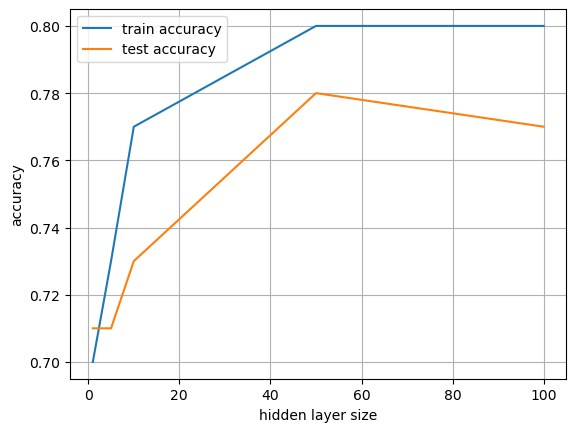

[0.688 0.726 0.766 0.8   0.796]
[[0.89 0.92 0.95 0.96 0.96]
 [0.72 0.77 0.82 0.85 0.84]
 [0.62 0.63 0.67 0.73 0.73]
 [0.46 0.53 0.62 0.66 0.64]
 [0.75 0.78 0.77 0.8  0.81]]


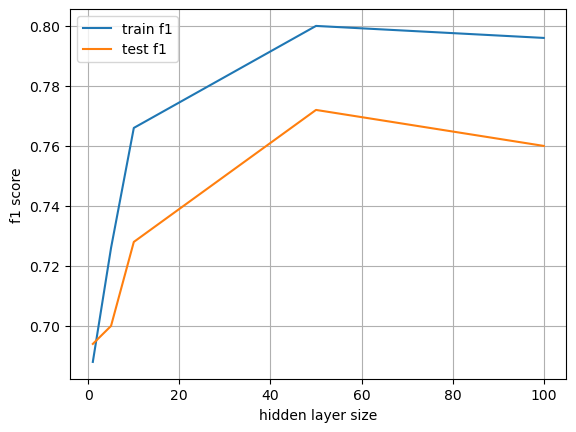

In [ ]:
hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc = read_logfile() 

# plotting train and test accuracies 
plot_accuracies([train_acc, test_acc], hidden_layers, ["train accuracy", "test accuracy"], "hidden layer size", "accuracy", "partb_accuracies") 
train_f1 = np.array(train_f1) 
train_f1_avg = np.mean(train_f1, axis = 0) 
test_f1 = np.array(test_f1)
test_f1_avg = np.mean(test_f1, axis = 0)
print(train_f1_avg)
print(train_f1) 
plot_accuracies([train_f1_avg, test_f1_avg], hidden_layers, ["train f1", "test f1"], "hidden layer size", "f1 score", "partb_f1")

# for i in range(1, 6):
#     for j in range(len(hidden_layers)):
#         print(f"for hidden layer {hidden_layers[j]}") 
#         print(f"class {i} train precision is {train_precision[i-1]}") 
#         print(f"class {i} test precision is {test_precision[i-1]}")
#         print(f"class {i} train recall is {train_recall[i-1]}")
#         print(f"class {i} test recall is {test_recall[i-1]}")
#         print(f"class {i} train f1 is {train_f1[i-1]}")
#         print(f"class {i} test f1 is {test_f1[i-1]}")
#         print()


## Comments
We see that f1 score is a good measure of generalization accuracy, since plots of test f1 score and test accuracy follow the same trend. Same holds for test data. 

In general, increasing the hidden layer size increases the test accuracy and test f1 score. 

We also observe that increasing the hidden layer size doesn't necessariliy increase f1 score. This could be due to overfitting of the model and loss of generalization accuracy with overly complex model . 

In [ ]:
class AdaptiveNeuralNetwork(Neural_Network):
    def __init__(self, minibatch_size, no_of_features, hidden_layers, no_of_classes):
        super().__init__(minibatch_size, no_of_features, hidden_layers, no_of_classes) 
        self.seed = 0.1 

In [ ]:
arr1 = np.array([[1,2,3], [4,5,6]]) 
arr2 = np.array([[5,6,7], [7,8,9]])
# arr3 = np.outer(arr1, arr2) 
# print(np.outer([1,2,4], [5,6,7]))
print(np.sum(arr1, axis=1))
arr3 = np.einsum('ij,ik->ijk', arr1, arr2) 
arr4 = np.sum(arr3.reshape(2, 3, 3), axis = 0)  
print(arr3) 
print(arr4)

def func(column):
    # Replace this with your custom function logic
    return column.sum()  # Example: Sum of each column

# Vectorize the function using np.apply_along_axis
result = np.apply_along_axis(func, axis=1, arr=arr1) 
print(result)


[ 6 15]
[[[ 5  6  7]
  [10 12 14]
  [15 18 21]]

 [[28 32 36]
  [35 40 45]
  [42 48 54]]]
[[33 38 43]
 [45 52 59]
 [57 66 75]]
[ 6 15]


In [ ]:
def compute_grad_z(y):
    phi = np.array([[0.5, 0.5], [0.5, 0.5]])  
    def temp(index):
        phi[index, y[index]] -= 1
        return 1   
    # self.grad_z[y] -= 1 
    vectorize_temp = np.vectorize(temp)
    vectorize_temp(np.arange(y.shape[0]))   
    # self.grad_z_sum += self.grad_z
    print(phi) 


def compute_loss(y):
    batch_loss = 0 
    phi = np.array([[0.5, 0.5], [0.5, 0.5]])
    def temp(index):
        batch_loss -= phi[index, y[index]] 
        return 1 
    vectorize_temp = np.vectorize(temp)
    vectorize_temp(np.arange(y.shape[0])) 
    print(batch_loss)

# arr = np.array([[1,2], [1,2], [1,2], [1,2], [1,2], [1,2]]) 
# # arr = arr.T 
# # print(arr)
# a = (np.array(np.split(arr, 3))) 
# for i in range(a.shape[0]): a[i] = a[i].T
# print(a)

# print(np.transpose([[1,2], [1,2]]))
# compute_grad_z(np.array([0,1])) 
# compute_loss(np.array([0,1]))  

# phis = np.array([[0.7, 0.5], [0.3, 0.9]]) 
# def temp(z) : return np.argmax(z)
# pred = np.apply_along_axis(temp, axis=0, arr=phis) 
# print(pred)

print(np.array([1,2,3]).reshape(-1, 1))


[[1]
 [2]
 [3]]
